In [107]:

import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [108]:
df = pd.read_excel('../data_processed/men_ordinary_people.xlsx')

In [109]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
0,poem good editing correct wish poem recorded ishq rasul studio,Abdulhaqpashai2,2023-03-13,male,pashtun,0,positive,0.700000
1,people bad things response answer,Abdulhaqpashai2,2023-03-04,male,pashtun,0,negative,-0.700000
2,dude go ahead stupidity god lead us right path years use stupidity stupidity,Abdulhaqpashai2,2023-02-27,male,pashtun,0,negative,-0.378571
3,busy personal work may god bless dear brother,Abdulhaqpashai2,2023-02-25,male,pashtun,0,positive,0.050000
4,busy personal work may god bless,Abdulhaqpashai2,2023-02-24,male,pashtun,0,positive,0.050000


##### Drop Null, Empty and NaN valeus

In [110]:
df.dropna(subset=['text'], inplace=True) # remove nan values
df.drop_duplicates(subset=['text'], inplace=True) # remove duplicates


##### Clean Data

In [111]:
df['text'] = df['text'].str.replace('&amp;', ' ')
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [112]:
# df = pd.read_excel('../data_processed/men_ordinary_people.xlsx')

In [113]:
df[['text']].sample(5)

,text
14192,drkarekar secret execution executed secret
32395,arendt warns us lose capacity solitude ability alone oneself also give away power think risk lose hustle bustle crowd find abandoned
34084,haqmal n much energy spend failure others spend success higher chance success energy
3874,tajmalokalam mirwaisashraf mohammad nabi sharafashraf rahmatshah mujeeb r amdadshinwari taj lala lamb
12286,individual afghanistan request twitter bantaliban


##### Remove Text Less then 30 characters

In [114]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [115]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [116]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [117]:
from nltk.corpus import stopwords
import nltk

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df

df = remove_stopwords(df)


##### Convert Timezone

In [118]:
# df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [119]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
21665,drfolladwand taliban afghanistan hazara cousins blast victims loved read learn inspire outdoor library,daichopanazmo,2023-03-17,male,hazara,0,positive,0.7
18798,tajudensoroush according voice attributed one taliban commanders saying punjabi guest reffering,Bagh_eBabur,2021-09-12,male,uzbek,0,neutral,0.0
9384,bahram aman threshold freedom collapse,MohammadeisaR,2022-07-22,male,tajik,0,neutral,0.0
7461,mr president mohammad nabi leading icc ranks,bashir_gharwall,2022-02-03,male,pashtun,0,neutral,0.0


In [120]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
33312,abdulrabhaqyar went shabarghan north loot kill take loot friend savages die kandahar paktia nangarhar,HamedRahimii,2022-03-18,male,tajik,0,neutral,0.0
6369,madihaafzal gatherings disgusting sat floor nothing mind people except saving share power lets include women nasty gatherings,baharmhr,2021-03-15,male,hazara,1,negative,-1.0
33303,rawitajik happy nowruz master ravi,HamedRahimii,2022-03-20,male,tajik,0,positive,0.8
32974,mariam tjk afghanyaar root thinking word afghanistan want afghans attack land home fight ethnic name country afghanistan changing ethnic name afghanistan name fara qoumi khorasanaz dries roots thinking,HamedRahimii,2022-05-12,male,tajik,0,neutral,0.0


##### Convert Timezone to datetime

In [121]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)


##### Drop the whole rows which is >=2020

In [122]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)

##### Remove Great March, 30

In [123]:
df.shape

(47939, 8)

In [124]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
47865,masalangi asilaa linarozbih crime crime wherever wherever committed damn ignorant criminals,ziaryaad,2021-03-06,male,pashtun,0,neutral,0.000000
501,stupid ignorant people world destroy country kill brother sake power,afghanistan1290,2023-02-28,male,pashtun,0,negative,-0.500000
8726,downingstreet rishisunak dear p minister wondering child immigrant raided offended pulled poor migrants came uk deport remove uk uk policymakers part responsible mass immigration loud voice fake arguments,matin_walizada,2022-12-17,male,tajik,0,negative,-0.150000
30626,mustafaqamari mirwais ashraf officially become new head afghan cricket board earlier chairman,MirwaisAshraf16,2022-01-17,male,pashtun,0,positive,0.068182


##### Check How Many accounts are there

In [125]:
len(df['name'].unique())

54

##### Labeling Process

In [126]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [127]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [128]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     19207
positive    17767
negative    10965
Name: count, dtype: int64
Total Counts: 28732


##### Calculate positive tweets and percentage for women, single user

In [129]:
women_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'male'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from men:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from men: 17767 ( 37.06168255491354 %)


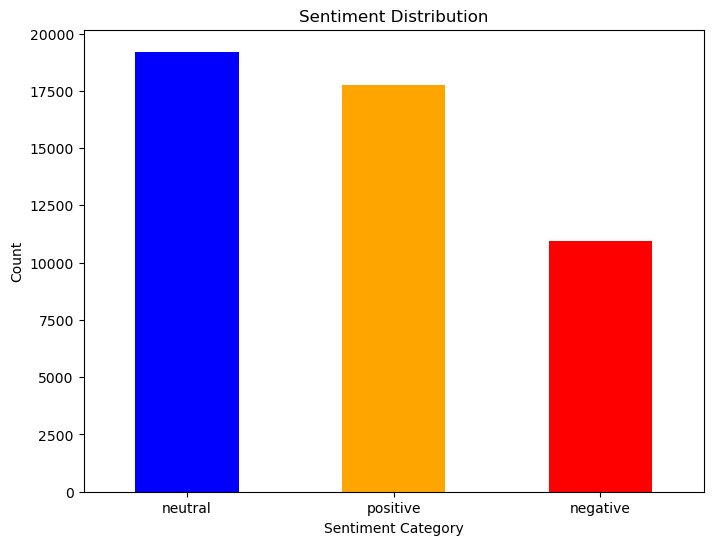

Sentiment Distribution: 28732


In [130]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Content Analysis

In [131]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  4383


##### Code Schema

In [132]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [133]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
8078,prime minister pakistan said conference islamic countries prohibiting girl studying part culture afghan pashtuns world respect afghanistan multinational country particular ethnic group favor banning girl education pakistans treatment afghanistan biased interventionist,positive,0.166667,male,1,"[women, education]"
27159,contemporary history afghanistan movement including constitutionalism movement clear picture demands rights ideals scale todays women movement unlike active political groups afghan women know well want want today tomorrow,positive,0.033333,male,1,[women]
529,qari belcha free alam gul haqqanis brother free caught drunkards girl mullah hebatak million afghanis paid victims turkish earthquake god bless life,positive,0.400000,male,1,[women]
22523,list hazara school children massacred wounded abdur rahim shahid school entire school children wiped face earth stop hazara genocide,neutral,0.000000,male,1,[school]
45997,taliban right dictate women wear women afghanistan rights like rest world yes women must allowed get education,positive,0.285714,male,1,"[women, education]"


##### Visualization

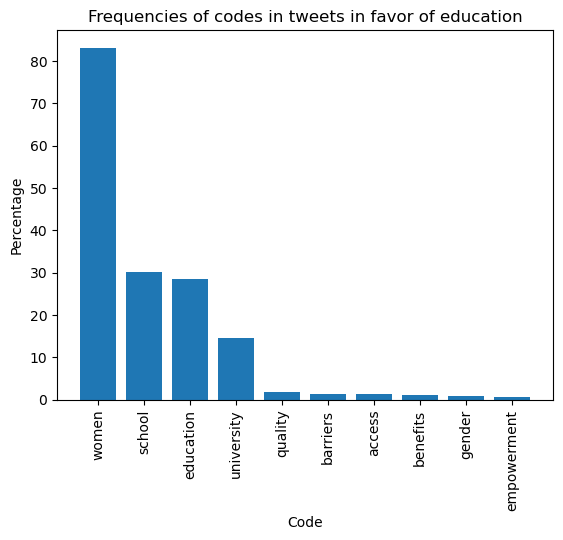

In [134]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [135]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    488
neutral     748
positive    783
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    227
neutral     284
positive    511
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    292
neutral     350
positive    350
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    138
neutral     221
positive    202
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative    365
neutral     521
positive    550
Name: text, dtype: int64


In [136]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13
neutral     14
positive    22
Name: text, dtype: int64


In [137]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13 (26.5%)
neutral     14 (28.6%)
positive    22 (44.9%)
Name: text, dtype: object


##### Average sentiment

In [138]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.05399835330957779


##### Sentiment Category

In [139]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)                     0.069273
(education, access)              0.003516
(education, access, barriers)    0.392857
(education, barriers)            0.321429
(education, benefits)            0.119722
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [140]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment Men:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment Men:
T-statistic: 41.46310984576854
P-value: 0.0


In [141]:
men_education_tweets = df[df['text'].str.contains('women education', case=False)]
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment for Women Education Tweets:
T-statistic: 1.5454343443610505
P-value: 0.1288094701752502


#### Calculate the sentiment scores for tweets containing each keyword

In [142]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.05399835330957779


##### Chi-square test of independence

In [143]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [144]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender      male
sentiment       
negative   10965
neutral    19207
positive   17767


In [145]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Gender and Label:")
print(cross_tab)

Cross-Tabulation of Gender and Label:
label       0     1
gender             
male    43556  4383


##### Calculate descriptive statistics for women


In [146]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for men ordinary people:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for men ordinary people:
Mean Sentiment: 0.05304848831657193
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.2801245010147825
Quartiles of Sentiment: [0.   0.   0.15]


##### Frequent Words

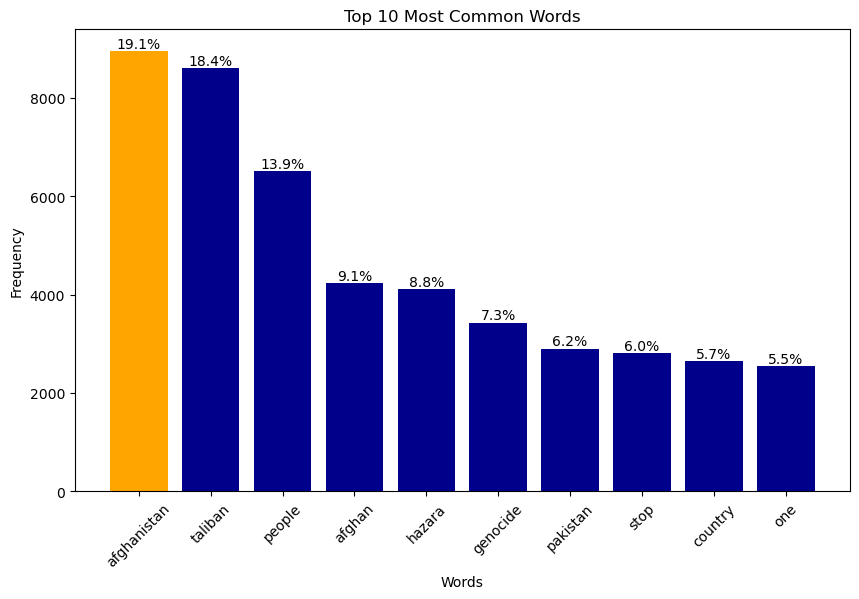

In [147]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


##### Time Series

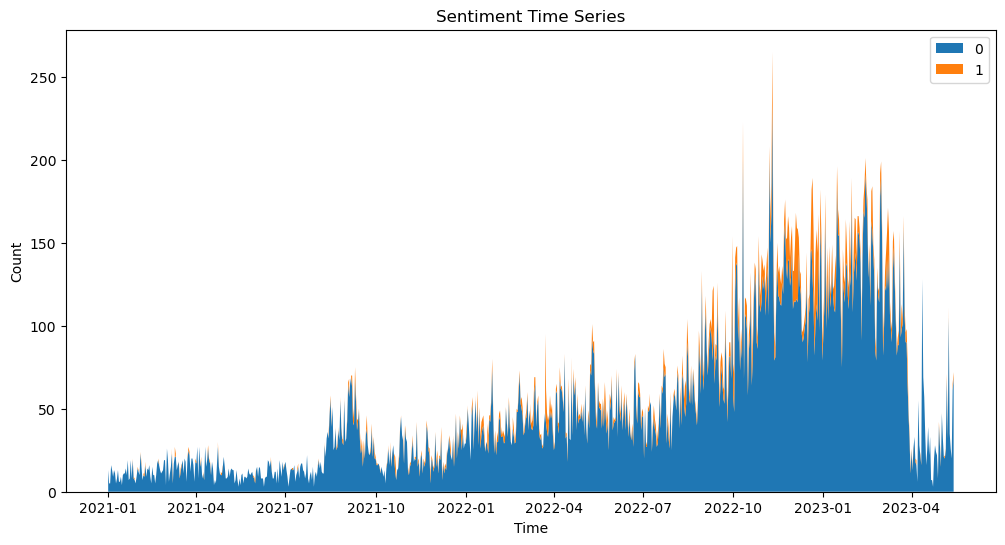

In [148]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Frequent Tweet

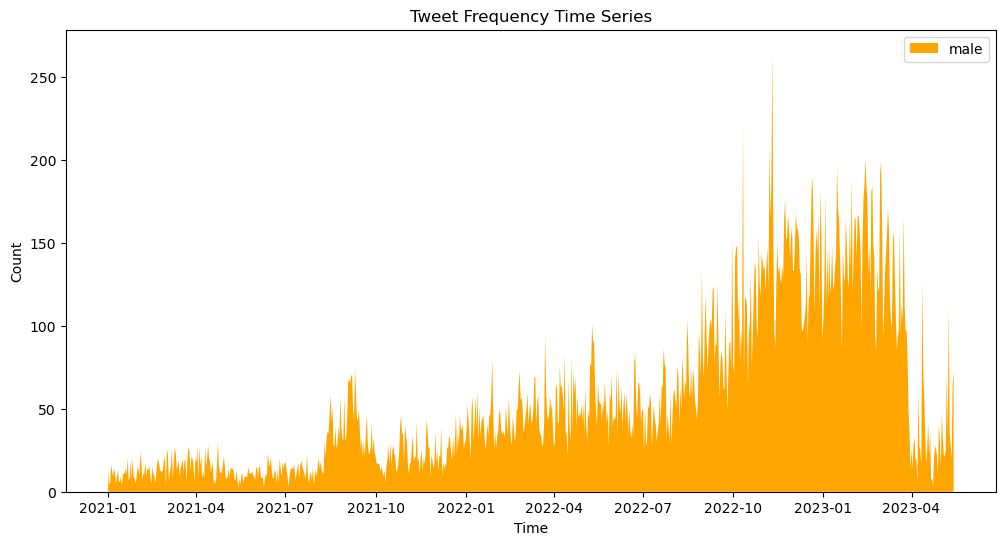

In [149]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


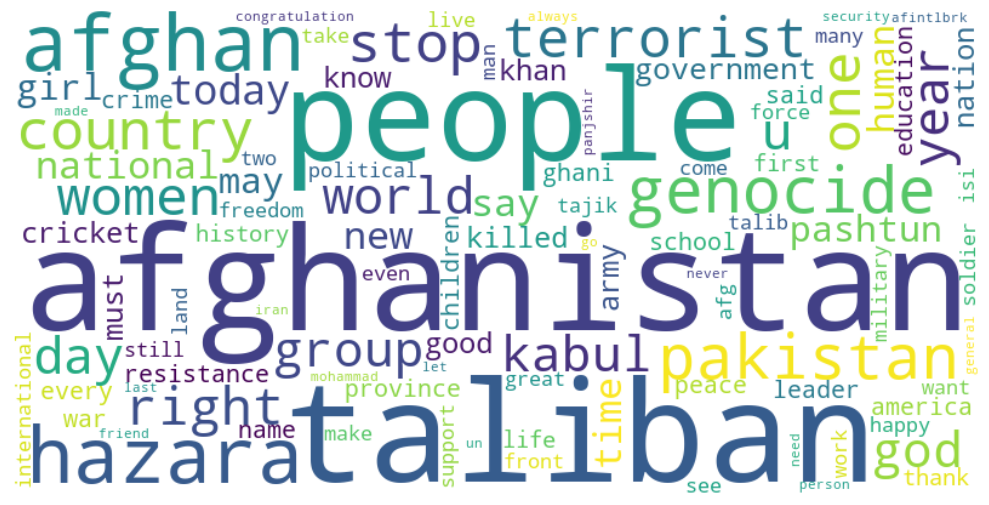

In [154]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


In [151]:
df[['text']].sample(7)

,text
41091,amutelevision best protect country
21436,madinahaidari afintlbrk people afghanistan talk
31498,achakzai javed time future dragon swimming blood pashtuns gentadinkhan siab
3461,acbofficials acbs media department interviewed national us head coach mr afghan cricket ongoing training preparatory
10331,fawadlameh standing committee foreign affairs parliament pakistan headed mohsin dawar asked munir akram return un meeting
4982,amrullahsaleh based document conspiracy regime change named peace process afgh handed talib
45408,us allies came afg paki army protected tbs trained prepared terrorist activitiessince isi handed pakhtunkhwa government mma last days mma terror activities started pti government nd phase isi starts terror game


In [152]:
df.shape

(47939, 8)

In [153]:
df.to_excel('../data_processed/men_ordinary_people.xlsx',index=False)